In [1]:
from collections import defaultdict

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# uint8 is not popular
y_train = y_train.astype('i4')
y_test = y_test.astype('i4')

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype('f4')
x_test = x_test[..., tf.newaxis].astype('f4')
n_train = x_train.shape[0]

In [64]:
class CVAELatent(tfk.Model):
    def __init__(self, latent_dist_fn, n_params):
        super(CVAELatent, self).__init__()
        
        self.latent_dist_fn = latent_dist_fn
        self.latent_prior = self.latent_dist_fn()

        self.encoder = tfk.Sequential([
            tfk.layers.Input((28, 28, 1)),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.MaxPool2D(),
            tfk.layers.Convolution2D(filters=32, kernel_size=3, activation='relu'),
            tfk.layers.MaxPool2D(),
            tfk.layers.Flatten(),
            tfk.layers.Dense(n_params, activation='relu'),
            tfp.layers.DistributionLambda(
                make_distribution_fn=self.latent_dist_fn,
                activity_regularizer=tfp.layers.KLDivergenceRegularizer(
                    self.latent_prior,
                    use_exact_kl=True,
                    weight=None,
                ),
            ),
        ])

        self.decoder = tfk.Sequential([
            tfk.layers.Input((26,)),
            tfk.layers.Dense(12*12*6, activation='relu'),
            tfk.layers.Reshape((12, 12, 6)),
            tfk.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'),
            tfk.layers.Conv2DTranspose(filters=32, kernel_size=4, activation='relu'),
            tfk.layers.Conv2DTranspose(filters=1, kernel_size=1, activation='sigmoid'),
            tfp.layers.IndependentBernoulli((1,)),
        ])
    
    def encode(self, inputs):
        '''Encode
        '''
        return self.encoder(inputs)
    
    def decode(self, inputs):
        '''Decode
        '''
        return self.decoder(inputs)
    
    def call(self, inputs):
        out = self.encode(inputs)
        out = self.decode(out)
        return out

In [65]:
def make_dist(inputs=None, *args, **kwargs):
    if inputs is None:
        beta1, beta0 = tf.ones(10), tf.ones(10) * 9
        mean, var = tf.zeros(16), tf.ones(16)
    else:
        beta1, beta0, mean, var = tf.split(inputs, [10, 10, 16, 16], axis=-1)
        # valid domain
        beta1, beta0, var = tf.exp(beta1), tf.exp(beta0), tf.exp(var)
    return tfd.Blockwise([
        tfd.Independent(tfd.Beta(beta1, beta0), reinterpreted_batch_ndims=1),
        tfd.MultivariateNormalDiag(loc=mean, scale_diag=var),
    ])

model = CVAELatent(make_dist, 10*2 + 16*2)
model.encoder.summary()
model.decoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 52)              

In [66]:
def analytic_kl(u1, s1, u2, s2):
    '''For two normal distributions'''
    return np.log(s2/s1) + (s1**2 + (u1 - u2)**2)/(2*(s2**2)) - .5

analytic_kl(.1, 1.1, 0, 1)

0.014689820195675218

In [67]:
optimizer = tfk.optimizers.Adam()

train_loss = tfk.metrics.Mean(name='train_loss')
test_loss = tfk.metrics.Mean(name='test_loss')

BATCH_SIZE = 100

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .batch(BATCH_SIZE, drop_remainder=True)
           )

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .batch(BATCH_SIZE, drop_remainder=True)
          )

In [68]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        output = model.call(images)
        nll = - output.log_prob(images)
        # Factor of 2: tensorflow/probability#599
        kl = tf.reduce_sum(model.losses) * BATCH_SIZE / n_train / 2.
        loss = tf.reduce_mean(nll) + kl

    trainable = model.trainable_variables
    gradients = tape.gradient(loss, trainable)
    optimizer.apply_gradients(zip(gradients, trainable))

    train_loss(loss)
    return loss

In [69]:
@tf.function
def test_step(images):
    output = model.call(images)
    loss = tf.reduce_mean(- output.log_prob(images))

    test_loss(loss)
    return loss

In [70]:
EPOCHS = 3
# history = defaultdict(list)

for epoch in tqdm.trange(EPOCHS, unit='epoch'):
    optimizer.lr = 1e-2
    for images, labels in train_ds:
        train_step(images)

    for test_images, test_labels in test_ds:
        test_step(test_images)

    history['train_loss'].append(float(train_loss.result()))
    history['test_loss'].append(float(test_loss.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    test_loss.reset_states()
    

100%|██████████| 3/3 [04:32<00:00, 90.80s/epoch]


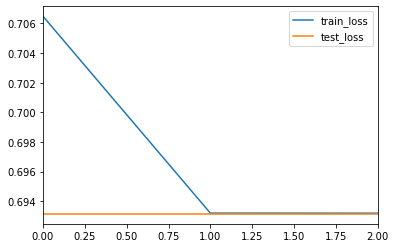

In [71]:
pd.DataFrame(history)[:].plot()

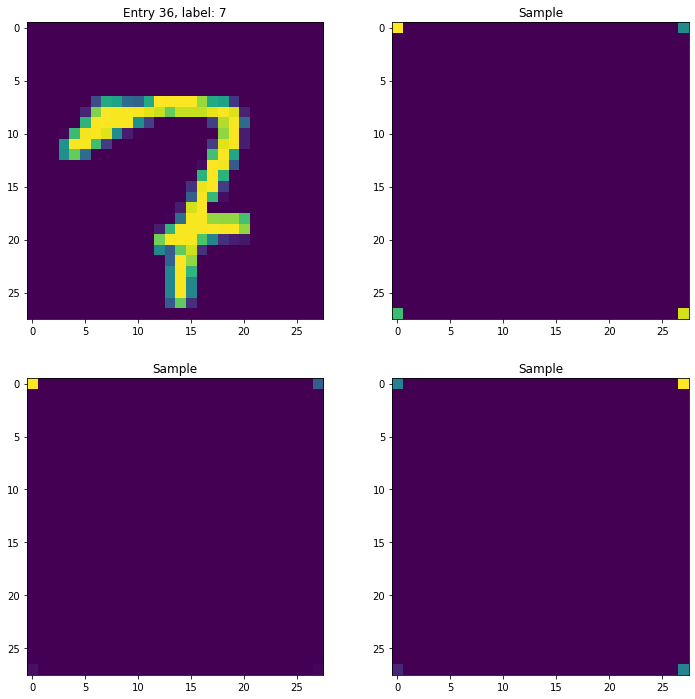

In [72]:
i = 36

ex = x_test[i,...,0]
lbl = y_test[i]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

axes[0][0].set_title("Entry %d, label: %d" % (i, lbl))
axes[0][0].imshow(ex)

latent = model.encode(ex[None, ..., None])

for ax in axes.flatten()[1:]:
    ax.set_title('Sample')
    ax.imshow(model.decode(latent.sample()).mean()[0, ..., 0])

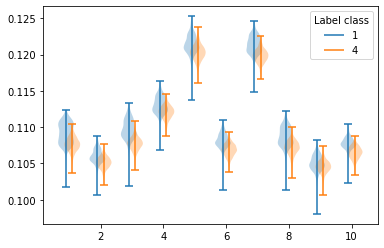

In [82]:
cut = y_test == 1
latent = model.encode(x_test[cut]).mean()
mlatent = latent.numpy()[:, :10]
vl1 = plt.violinplot(mlatent, positions=np.arange(10) + .9)

cut = y_test == 4
latent = model.encode(x_test[cut]).mean()
mlatent = latent.numpy()[:, :10]
vl4 = plt.violinplot(mlatent, positions=np.arange(10) + 1.1)

plt.legend([vl1['cbars'], vl4['cbars']], ['1', '4'], title='Label class')